In [31]:
# imports
import pandas as pd
import numpy as np
from pdpbox import pdp, info_plots
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce

In [32]:
# load in the dataset -- change filepath as appropriate
df = pd.read_csv(r"../data/restaurant data/restaurants.csv", parse_dates=['visit_date'])

In [33]:
# let's fill in our missing values for now
df = df.fillna(0)

# sort values
df.sort_values(by=['id', 'visit_date'], ascending=True, inplace=True)
# we'll create this column for display purposes
df['city']    = df['area'].str.split('-').str[0]
df['week']    = df['visit_date'].dt.week
df['month']   = df['visit_date'].dt.month
df['quarter'] = df['visit_date'].dt.quarter
df['year']    = df['visit_date'].dt.year
df['time']    = (df['visit_date'] - df['visit_date'].min()).dt.days

# create training & test sets
train = df.groupby('id').apply(lambda x: x.iloc[:-15])
test  = df.groupby('id').apply(lambda x: x.iloc[-15:])

# and do our splits
X_train, y_train = train.drop(['visit_date', 'calendar_date', 'visitors'], axis=1), train['visitors']
X_test, y_test   = test.drop(['visit_date', 'calendar_date', 'visitors'], axis=1), test['visitors']

In [34]:
# will be useful for interpretation
col_mapping = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

In [35]:
# setup our model -- using the onehot encoder -- makes these things a *little* easier to rende
pipe = make_pipeline(ce.TargetEncoder(cols=['id']),
                     ce.OrdinalEncoder(cols=['day_of_week'], mapping=[{'col': 'day_of_week', 'mapping': col_mapping}]),
                     ce.OneHotEncoder(use_cat_names=True),
                     GradientBoostingRegressor())
# and fit
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('targetencoder',
                 TargetEncoder(cols=['id'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               min_samples_leaf=1, return_df=True,
                               smoothing=1.0, verbose=0)),
                ('ordinalencoder',
                 OrdinalEncoder(cols=['day_of_week'], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[{'col': 'day_of_week',
                                          '...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                     

In [36]:
transformed_X = pipe[2].transform(pipe[1].transform(pipe[0].transform(X_train)))

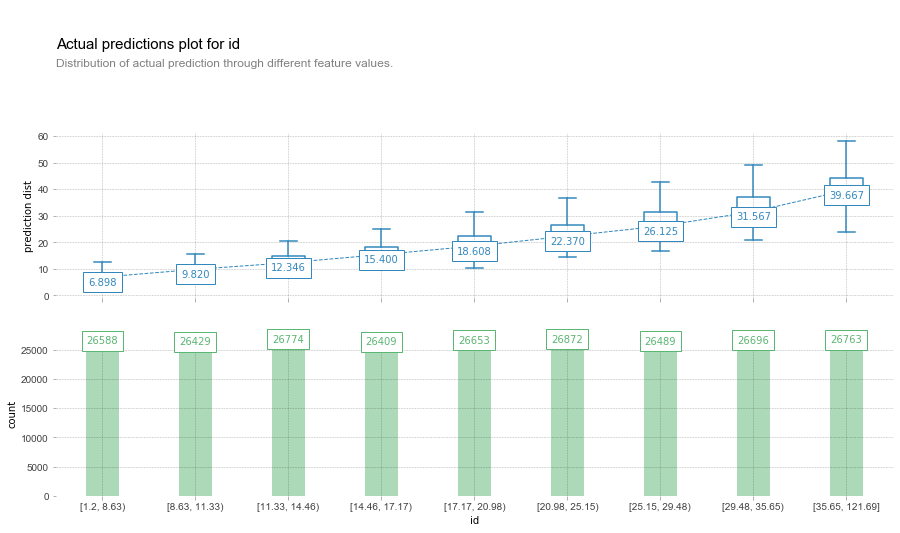

In [37]:
# this chart summarizes the model predictions made for each unique value in the day_of_week column
fig, axes, summary_df = info_plots.actual_plot(
    # notice these options -- accesing the appropriate parts of our pipeline to get the data setup
    model=pipe[3], X=transformed_X, 
    feature='id', feature_name='id', predict_kwds={}
)

In [21]:
# chart is being created from this variable
summary_df

,x,display_column,value_lower,value_upper,count,actual_prediction_q1,actual_prediction_q2,actual_prediction_q3
0,0,"[1.2, 8.63)",1.200000,8.631148,26588,5.587952,6.898340,8.345695
1,1,"[8.63, 11.33)",8.631148,11.333333,26429,8.598645,9.820247,11.479355
2,2,"[11.33, 14.46)",11.333333,14.461832,26774,10.834459,12.345827,14.794924
3,3,"[14.46, 17.17)",14.461832,17.170918,26409,13.434851,15.400356,18.109024
4,4,"[17.17, 20.98)",17.170918,20.982673,26653,15.885464,18.608048,22.341939
5,5,"[20.98, 25.15)",20.982673,25.150649,26872,19.588714,22.370235,26.567447
6,6,"[25.15, 29.48)",25.150649,29.476190,26489,23.233154,26.124873,31.542375
7,7,"[29.48, 35.65)",29.476190,35.647702,26696,27.456582,31.566998,37.235395
8,8,"[35.65, 121.69]",35.647702,121.694444,26763,35.211427,39.667362,44.430090


Now, let's build our actual PARTIAL DEPENDENCE PLOT.

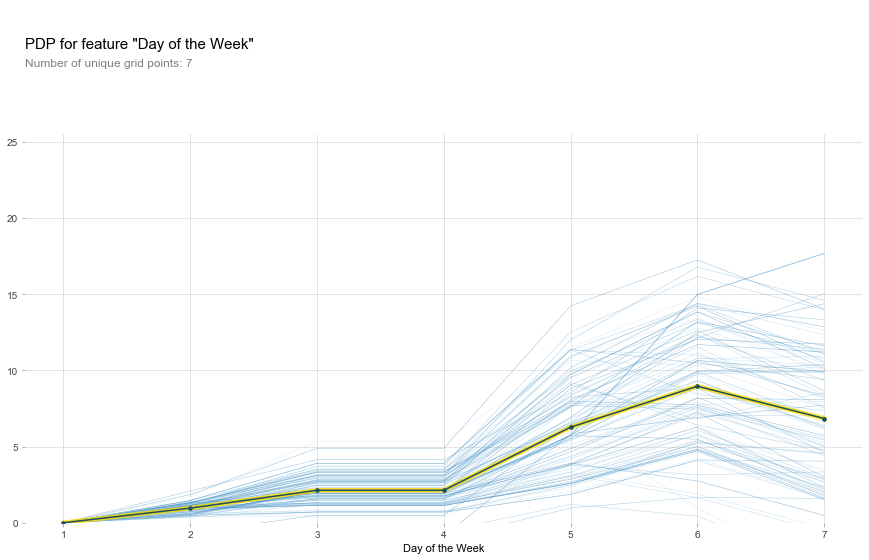

In [22]:
# what was the additive impact of EACH unique value of OverallQual?  What was its marginal impact?
pdp_day_of_week = pdp.pdp_isolate(
    model=pipe[3], dataset=transformed_X, model_features=transformed_X.columns.tolist(), 
    feature='day_of_week', cust_grid_points = transformed_X['day_of_week'].unique().tolist()
)

fig, axes = pdp.pdp_plot(pdp_day_of_week, 'Day of the Week', plot_lines=True, frac_to_plot=100)

In [23]:
pdp_day_of_week.pdp

array([16.92757225, 17.88621929, 19.05943818, 19.05943818, 23.20078163,
       25.88894373, 23.76887373])

### PDP for OneHot Encoded Columns

Lots of times your categorical data will be one hot encoded.  PDP plots render a bit more naturally if your data is setup this way, so it's a good idea to keep this in mind if you want to run these plots.  Let's setup our model to one hot encode the `genre` column and see how we can get these values to render.

In [24]:
# create a new pipeline -- this time onehot encoding the genre column
pipe = make_pipeline(ce.OneHotEncoder(cols=['city'], use_cat_names=True), ce.TargetEncoder(), GradientBoostingRegressor())
# fit our model again
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['city'], drop_invariant=False,
                               handle_missing='value', handle_unknown='value',
                               return_df=True, use_cat_names=True, verbose=0)),
                ('targetencoder',
                 TargetEncoder(cols=['id', 'day_of_week', 'genre', 'area'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', min_samples_leaf=1,
                               return...
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
 

In [39]:
# first, let's grab the columns with genre in them
city_cols = [col for col in pipe[2].get_feature_names() if 'city' in col]
city_cols

['city_Tōkyō',
 'city_Ōsaka',
 'city_Hyōgo',
 'city_Hiroshima',
 'city_Fukuoka',
 'city_Hokkaidō Sapporo',
 'city_Miyagi',
 'city_Niigata',
 'city_Hokkaidō Asahikawa',
 'city_Hokkaidō Abashiri',
 'city_Shizuoka',
 'city_Hokkaidō Katō']

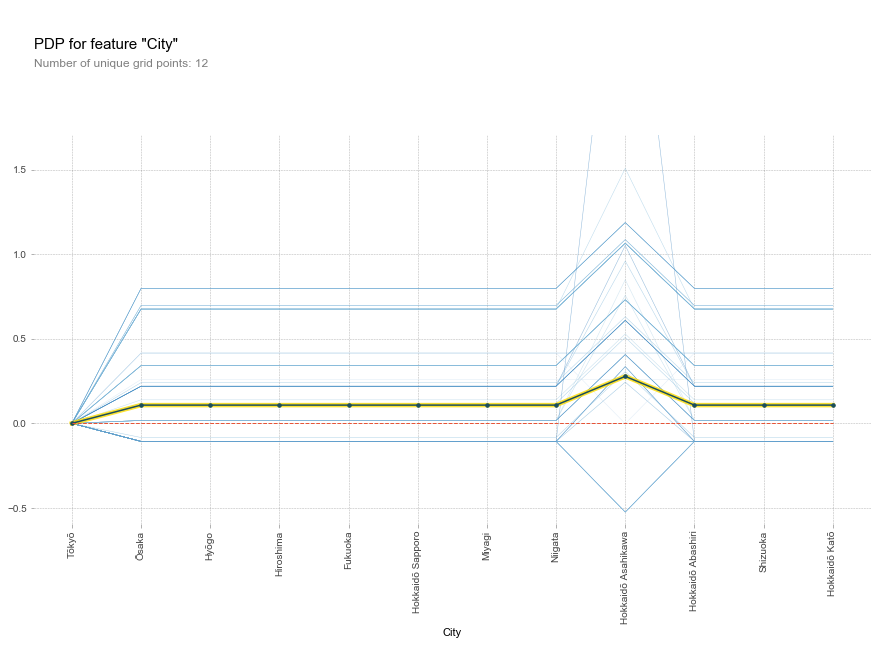

In [41]:
# and what about categorical variables?
# what was the impact of genre on attendance?
pdp_city = pdp.pdp_isolate(
                    # dataset -- create the final transformation of our data
    model=pipe[3], dataset=transformed_X, model_features=pipe[2].get_feature_names(), 
    # this is the list of all the columns for the genre feature
    feature=city_cols
)

fig, axes = pdp.pdp_plot(pdp_city, 'City', plot_lines=True, frac_to_plot=100)
# this code is just for formatting -- getting the labels to format correctly
xtick_labels = [city.split('_')[1] for city in city_cols]
axes['pdp_ax'].set_xticklabels(xtick_labels, rotation='vertical');

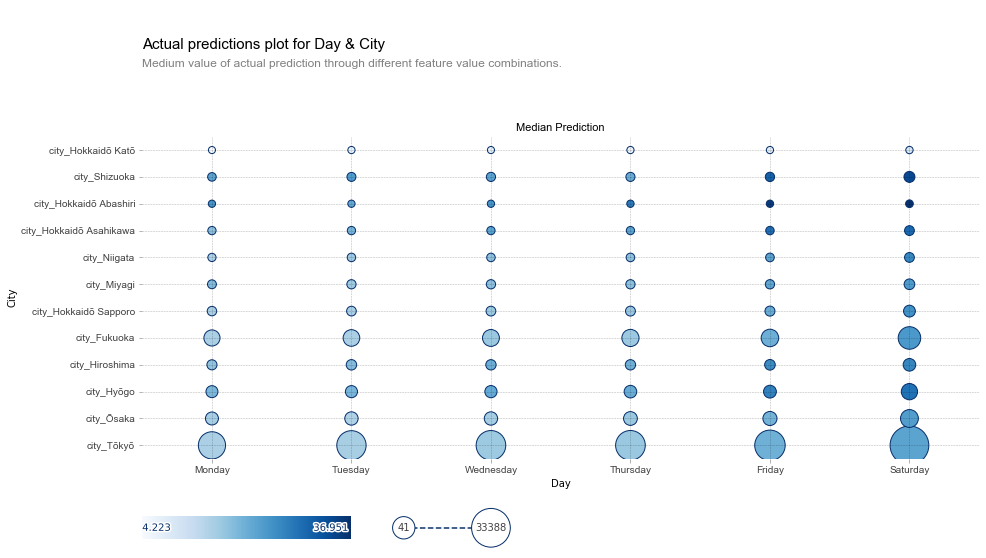

In [43]:
# and what about interactions?
fig, axes, summary_df = info_plots.actual_plot_interact(
    model=pipe[3], X=transformed_X, 
    features=['day_of_week', city_cols], 
    feature_names=['Day', 'City']
)

axes['value_ax'].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

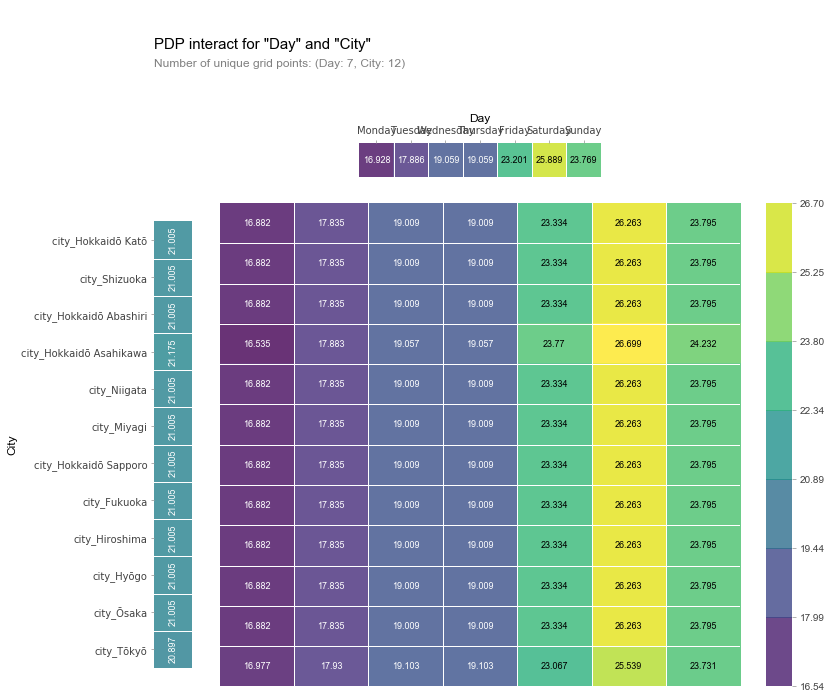

In [44]:
# and a slightly different look at the same problem
gbm_inter = pdp.pdp_interact(
    model=pipe[3], dataset=transformed_X, model_features=pipe[2].get_feature_names(), 
    features=['day_of_week', city_cols]
)


fig, axes = pdp.pdp_interact_plot(
    gbm_inter, ['Day', 'City'], x_quantile=True, plot_type='grid', plot_pdp=True
)
axes['pdp_inter_ax']['_pdp_inter_ax'].set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation='vertical');

In [45]:
# this is the dataset used to generate the above plot
gbm_inter.pdp

,day_of_week,city_Tōkyō,city_Ōsaka,city_Hyōgo,city_Hiroshima,city_Fukuoka,city_Hokkaidō Sapporo,city_Miyagi,city_Niigata,city_Hokkaidō Asahikawa,city_Hokkaidō Abashiri,city_Shizuoka,city_Hokkaidō Katō,preds
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.882393
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,16.882393
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,16.882393
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,16.534838
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16.882393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,7.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.795129
80,7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.795129
81,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.795129
82,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.795129
